# Hands-On 1: Portable Parallel Programming with OpenMP

Welcome to Hands-on _Portable Parallel Programming with OpenMP_. This notebook comprises 2 sessions. Next table shows the documents and files needed to develop each one of the exercises.


|  Sessions     | Codes             | files           | 
| --------------| ----------------- | --------------- |
| Session 1     | Matrix Multiply   |  mm.c           |  
| Session 2     | Asynchronous Task |  asyncTaskOpenMP.c |   


## `Matrix Multiple Benchmark`

The definite algebraic operation of the matrix can be defined as:For your work today, you have access to several GPUs in the cloud. Run the following cell to see the GPUs available to you today.

$$ c_{ij} = \sum\limits_{k=1}^{n } a_{ik} b_{kj} = a_{i1}b_{1j} + a_{i2}b_{2j} + ... + a_{in}b_{nj} $$

where $i$ is summed over for all possible values of $j$ and $k$ and the notation above uses the summation convention. The sequential code of the program is available in the file `mm.c`. The follow code shows an extract of such code. In particular, we can see the algebraic operation include a loop that implements the summatory of the above definition.

In [18]:

%%writefile mm.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
int  *A;
int  *B; 
int  *C;
int size;
int num_threads;

void writeResultsToFile(int size, double sequential_time, double parallel_time, double parallel_collapse_reduction_time, double speedup) {
    FILE *result_file = fopen("resultFile.txt", "a");
    if (result_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    } 

    fprintf(result_file, "%d %lf %lf %lf %f\n", size, sequential_time, parallel_time, parallel_collapse_reduction_time, speedup);
    if(size == 1000) fprintf(result_file, "\n");

    fclose(result_file);
}

void initializeMatrix(int *matrix, int size)
{
  for(int i = 0; i < size; i++)
    for(int j = 0; j < size; j++)
      matrix[i * size + j] = rand() % (10 - 1) * 1;
}

void multiply_sequential(){
  int i, j, k;
  for(i = 0; i < size; i++)
    for(j = 0; j < size; j++)
      for(k = 0; k < size; k++)
        C[i * size + j] += A[i * size + k] * B[k * size + j];
}

void multiply_parallel(){
  int i, j, k;
  #pragma omp parallel for private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      if (i == 0 && j == 0) num_threads = omp_get_num_threads();
      for(k = 0; k < size; k++)
        C[i * size + j] = A[i * size + k] * B[k * size + j];
    }
  } 
}

void multiply_parallel_collapse_reduction(){
  int i, j, k;
  #pragma omp parallel for collapse(2) private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      if (i == 0 && j == 0) num_threads = omp_get_num_threads();
      int ans = 0;
    #pragma omp simd reduction(+ : ans)
      for(k = 0; k < size; k++){
        ans += A[i * size + k] * B[k * size + j];
      }
      C[i * size + j] = ans;
    }
  } 
}

int main (int argc, char **argv)
{
  size = atoi(argv[1]);  
  int i, j, k;
  double sequential_start, sequential_end, parallel_start, parallel_end, parallel_cr_start, parallel_cr_end; 

  A = (int *) malloc (sizeof(int)*size*size);
  B = (int *) malloc (sizeof(int)*size*size);
  C = (int *) malloc (sizeof(int)*size*size);

  initializeMatrix(A, size);
  initializeMatrix(B, size);

  // Sequential
  sequential_start = omp_get_wtime();
  multiply_sequential();
  sequential_end = omp_get_wtime();
  
  // Parallel
  parallel_start = omp_get_wtime();
  multiply_parallel();
  parallel_end = omp_get_wtime();

  // Parallel collapse reduction
  parallel_cr_start = omp_get_wtime();
  multiply_parallel_collapse_reduction();
  parallel_cr_end = omp_get_wtime();
  
  double sequential_time = sequential_end - sequential_start; // Sequencial time
  double parallel_time = parallel_end - parallel_start; // Parallel time
  double parallel_collapse_reduction_time = parallel_cr_end - parallel_cr_start; // Parallel collapse reduction time

  double speedup = sequential_time / parallel_collapse_reduction_time;

  writeResultsToFile(size, sequential_time, parallel_time, parallel_collapse_reduction_time, speedup);
  printf("Speedup: %f\n", speedup);

  return 0;
}



Overwriting mm.c


### Run the Code

In [10]:
!gcc-14  mm.c -o mm -fopenmp

1073.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [11]:
%%writefile start.sh
#!/bin/sh

for ((i=1; i<=8; i++))
do
  echo "Number of threads:" $i "=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-="  
  for ((j=200; j<=1000; j+=200))
  do
    OMP_NUM_THREADS="$i" ./mm "$j"
  done
  echo 
done

Overwriting start.sh


In [12]:
!bash start.sh

1079.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Number of threads: 1 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Speedup: 2.049322
Speedup: 2.101757
Speedup: 1.804137
Speedup: 1.923651
Speedup: 2.113678

Number of threads: 2 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Speedup: 3.174863
Speedup: 3.586606
Speedup: 4.586635
Speedup: 3.601221
Speedup: 4.551783

Number of threads: 3 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Speedup: 5.221154
Speedup: 5.082806
Speedup: 5.752569
Speedup: 5.906951
Speedup: 5.678542

Number of threads: 4 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Speedup: 5.495283
Speedup: 4.982575
Speedup: 7.163462
^C


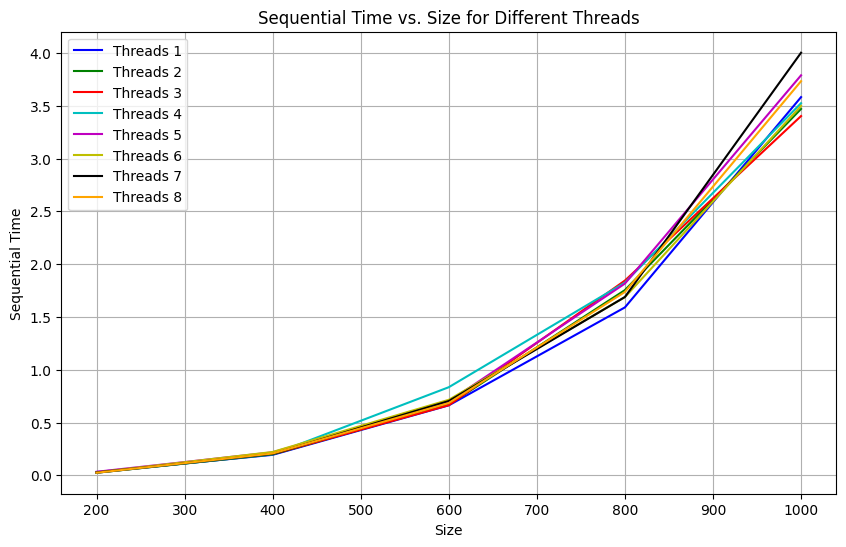

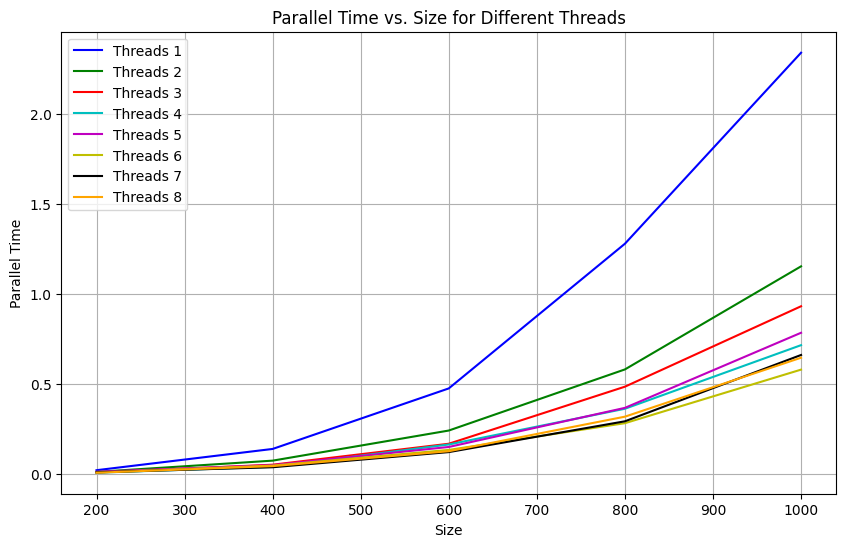

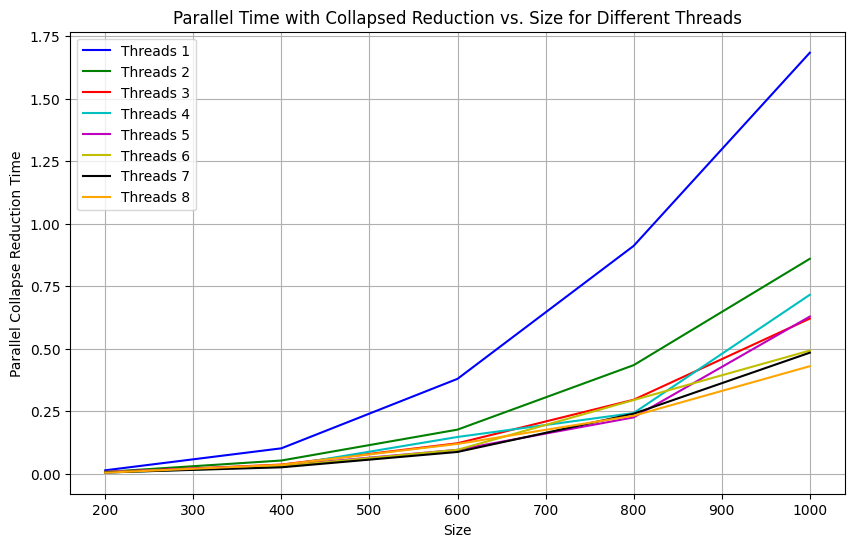

In [8]:
import matplotlib.pyplot as plt

# Function to plot graphs
def plot_graph(x_data, y_data, title, y_label, legend_labels):
    plt.figure(figsize=(10, 6))
    
    # Adjust the number of labels and colors based on the available data
    num_lines = min(len(x_data), len(legend_labels), len(colors))
    
    for i in range(num_lines):
        plt.plot(x_data[i], y_data[i], label=legend_labels[i], color=colors[i])

    plt.xlabel('Size')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Lists to store the data
sizes = []
sequential_times = []
parallel_times = []
parallel_collapse_reduction_times = []

# List of colors for the lines
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

# List of threads for the legend
threads = [1, 2, 3, 4, 5, 6, 7, 8]

# Open the file and read the data
with open('resultFile.txt', 'r') as file:
    lines = file.readlines()
    current_data = []  # Stores the data of the current block
    for line in lines:
        if line.strip():  # Check if the line is not empty
            values = line.split()
            size = int(values[0])
            sequential_time = float(values[1])
            parallel_time = float(values[2])
            parallel_collapse_reduction_time = float(values[3])
            current_data.append((size, sequential_time, parallel_time, parallel_collapse_reduction_time))
        else:
            # A new blank line indicates the start of a new block
            sizes.append([data[0] for data in current_data])
            sequential_times.append([data[1] for data in current_data])
            parallel_times.append([data[2] for data in current_data])
            parallel_collapse_reduction_times.append([data[3] for data in current_data])
            current_data = []

# Ensure the remaining data is added after the last block
if current_data:
    sizes.append([data[0] for data in current_data])
    sequential_times.append([data[1] for data in current_data])
    parallel_times.append([data[2] for data in current_data])
    parallel_collapse_reduction_times.append([data[3] for data in current_data])

# Plot the graph for Sequential Time
plot_graph(sizes, sequential_times, 'Sequential Time vs. Size for Different Threads', 'Sequential Time', [f'Threads {thread}' for thread in threads])

# Plot the graph for Parallel Time
plot_graph(sizes, parallel_times, 'Parallel Time vs. Size for Different Threads', 'Parallel Time', [f'Threads {thread}' for thread in threads])

# Plot the graph for Parallel Collapse Reduction Time
plot_graph(sizes, parallel_collapse_reduction_times, 'Parallel Time with Collapsed Reduction vs. Size for Different Threads', 'Parallel Collapse Reduction Time', [f'Threads {thread}' for thread in threads])


## Answers:
### Question 1:
##### What is the behavior of execution time and speedup as the problem size varies? (Present the solution with tabular and graphical data).
#### When running tests on a MacBook with 8 threads, which were also being used by other programs and the operating system, the results were significant. Execution times in sequential mode were quite high. In parallel mode, execution time decreased significantly, with the optimal performance observed with 6 threads for non-collapsed reduction and 8 threads for collapsed reduction. For instance, using only 1 thread consistently performed poorly compared to other configurations, likely due to the thread being utilized by the operating system. In all the parallel cases the thread 1 was considerably not as performatic as the other ones due to the OS using it.


### Question 2:
##### What is the optimal number of threads for the best parallel solution?
##### The optimal number of threads is 8.



# Asynchronous Task


In [ ]:
%%writefile async.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#define SIZE_MATRIX 10

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);
  int block_size = atoi(argv[2]);
  int matrix[SIZE_MATRIX][SIZE_MATRIX];
  int k[5] = {10, 20, 30, 40, 50}; 
  // adicionando as variáveis k3 e k4 para poder multiplicar os valores da matriz
  int i, j, row, column;

  for(i = 0; i < n; i++)
  {
    for(j = 0; j < n; j++)
    {
      matrix[i][j] = 5;
      printf("%d\t", matrix[i][j]);
    }
    printf("\n");
  }

  printf("\n\n");

  omp_set_num_threads(5);
  #pragma omp parallel private(row, column)
  {
    int id = omp_get_thread_num();
    if(id == 0)
    {
      for(row = 0; row < n; row++)
        for(column = 0; column < block_size; column++)
          matrix[row][column] *= k[id];
    }

    if(id == 1)
    {
      for(row = 0; row < n; row++)
        for(column = block_size; column < 2 * block_size; column++)
          matrix[row][column] *= k[id];
    }

    if(id == 2)
    {
        for(row = 0; row < n; row++)
        for(column = 2 * block_size; column < 3 * block_size; column++)
          matrix[row][column] *= k[id];
    }

    if(id == 3)
    {
        for(row = 0; row < n; row++)
        for(column = 3 * block_size; column < 4 * block_size; column++)
          matrix[row][column] *= k[id];
    }
    if (id == 4)
    {
        for(row = 0; row < n; row++)
        for(column = 4 * block_size; column < 5 * block_size; column++)
          matrix[row][column] *= k[id];
    }

   }

  for(i = 0; i < n; i++)
  {
    for(j = 0; j < n; j++)
      printf("%d\t", matrix[i][j]);
    printf("\n");
  }

  return 0;
}



In [22]:
!gcc async.c -o asyncTaskOpenMP -fopenmp

1678.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


cc1: fatal error: async.c: No such file or directory
compilation terminated.


In [24]:
!./async 10 2

1716.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	
5	5	5	5	5	5	5	5	5	5	


50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	
50	50	100	100	150	150	200	200	250	250	


## Answers:
### Question 1:
##### What does the code do from the compilation and execution of the previous code?
##### The code is designed to split the matrix into segments, with each thread handling operations on its assigned segment separately. 

### Question 2:
##### How would it be possible to extend the code so that the five threads perform asynchronous tasks?
##### Adding the new values of k to the matrix and adding the if statement to the parallel code


## References

M. Boratto. Hands-On Supercomputing with Parallel Computing. Available: https://github.com/muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing. 2022.

B. Chapman, G. Jost and R. Pas. Using OpenMP: Portable Shared Memory Parallel Programming. The MIT Press, 2007, USA.